In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import lzma
import re
from math import ceil

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 1000
#plt.style.use('ggplot')
plt.style.use('seaborn-paper')
mpl.rcParams['axes.linewidth'] = 0.7

In [2]:
def get_path(path):
    return re.search("(/[^/]+){2}$", path)[0][1:]

In [3]:
file = "latest_results.json.xz"

data = None
if file.endswith('.xz'): file = lzma.open(file, 'rt')
data = pd.read_json(file)
data = data.sort_values(['file', 'mode'])

short_paths = data['file'].map( get_path )
data.update( short_paths )

In [4]:
succeeded = data[data.status == 'ok'][['file', 'mode', 'time_viper', 'time_viper_axiom_gen', 'inductions', 'induction_depth', 'candidates', 'added_axioms', 'quantified', 'atomic']]

In [5]:
len(succeeded)

586

In [6]:
states = set(data.status.values)
status_colors = {}
for s in states:
    if s == 'ok':
        c = 'green'
    elif s == 'cutintro_uncompressible':
        c = 'yellow'
    elif s == 'cutintro_termset_trivial':
        c = 'gold'
    elif 'timeout' in s:
        c = plt.cm.Blues(hash(s)/2**65+0.5)
    elif s.endswith('exception'):
        c = plt.cm.Reds(hash(s)/2**65+0.5)
    else:
        c = plt.cm.Greys(hash(s)/2**65+0.5)
    status_colors[s] = c

def plot_status(d, legend=True, **kwargs):
    plt.axis('equal')
    d.plot(kind='pie', autopct='%1.1f%%',
                        colors=[status_colors[s] for s in d.index], **kwargs) \
        .set_ylabel('')
    if legend: plt.legend(d.index, loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
data_by_mode = data.groupby('mode')
modes = set( data['mode'].values )

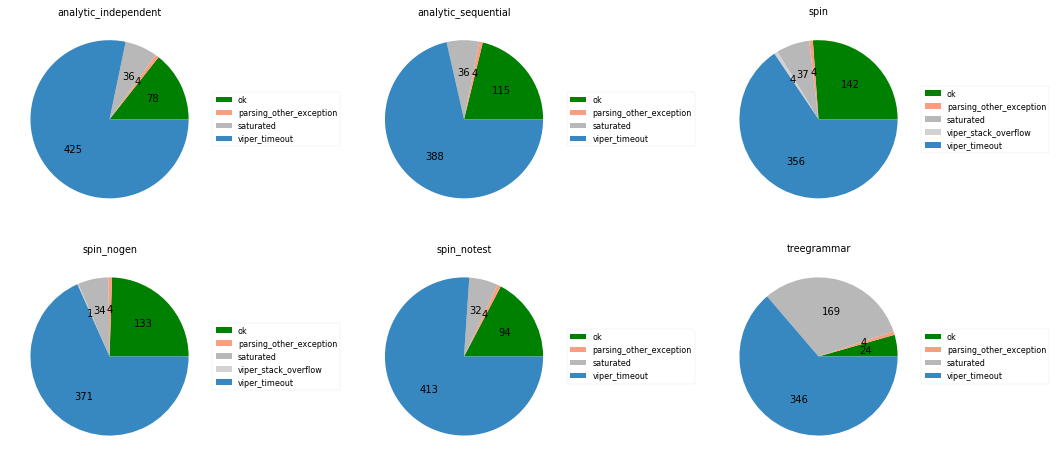

In [8]:
cols = int(ceil(len(modes) / 2))
fig, ax = plt.subplots(nrows = 2, ncols = cols, figsize = (18, 8))

for (i, mode) in enumerate( sorted( modes ) ):
    data_mode = data[data['mode'] == mode]
    p = ax[int(i / cols)][int(i % cols)]
    d = data_mode.groupby('status').size()
    total = sum(d)
    p.pie(d, autopct=lambda p: '{:.0f}'.format(p * total / 100), colors=[status_colors[s] for s in d.index])
    p.legend(d.index, loc='center left', bbox_to_anchor=(1, 0.5))
    p.set_title( mode )

In [9]:
succeeded.groupby('mode').size()

mode
analytic_independent     78
analytic_sequential     115
spin                    142
spin_nogen              133
spin_notest              94
treegrammar              24
dtype: int64

In [10]:
spin_success = succeeded[succeeded['mode'] == 'spin']
spin_files = set(spin_success.T.loc['file'])

In [11]:
total_files = len( spin_success )

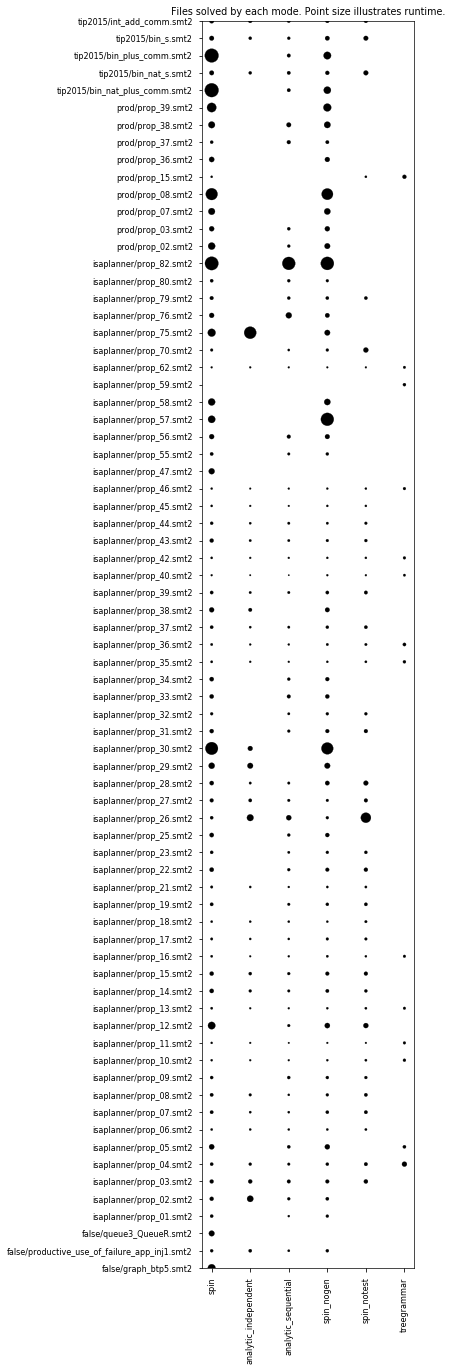

In [12]:
plt.figure( figsize=(6, 19) )
plt.xticks( rotation = 90 )
plt.scatter( succeeded['mode'], succeeded['file'], s=succeeded['time_viper'] / 500, color='black' )
plt.ylim(0, total_files / 2 + 1)
plt.tight_layout()
plt.title( "Files solved by each mode. Point size illustrates runtime." )
plt.savefig( "scatter1.pdf" )

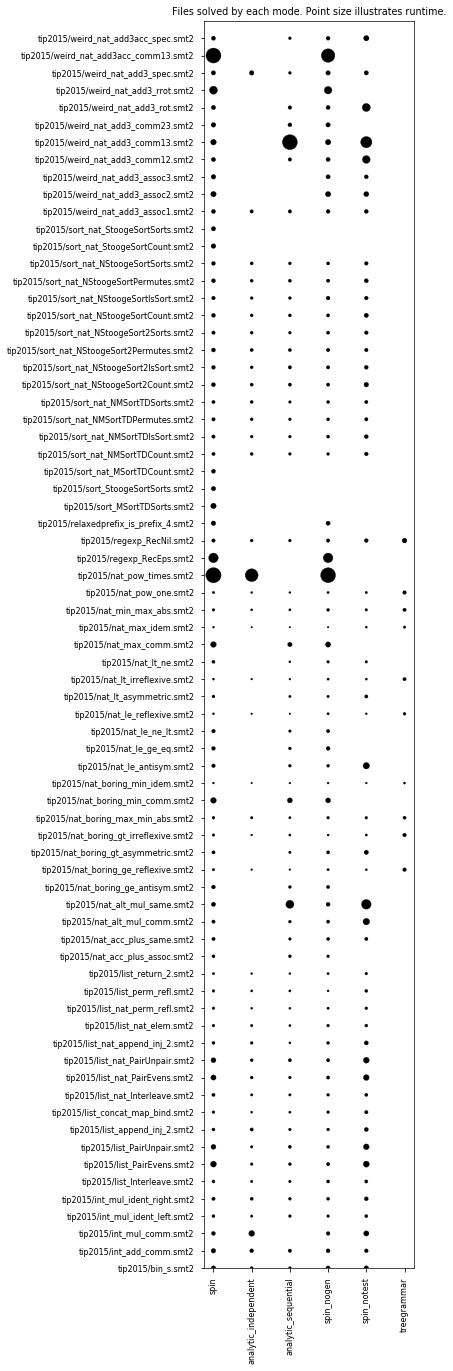

In [13]:
plt.figure( figsize=(6, 19) )
plt.xticks( rotation = 90 )
plt.scatter( succeeded['mode'], succeeded['file'], s=succeeded['time_viper'] / 500, color='black' )
plt.ylim(total_files / 2, total_files+1)
plt.tight_layout()
plt.title( "Files solved by each mode. Point size illustrates runtime." )
plt.savefig( "scatter2.pdf" )

Not solved by Spin:

In [14]:
for mode in sorted( modes ):
    succ = succeeded[succeeded['mode'] == mode]
    files = set(succ.T.loc['file'])
    diff = files - spin_files
    print( mode + ": " + str( diff ) )

analytic_independent: set()
analytic_sequential: set()
spin: set()
spin_nogen: set()
spin_notest: set()
treegrammar: {'isaplanner/prop_59.smt2'}


Solved by Spin, but not the other:

In [15]:
for mode in sorted( modes ):
    succ = succeeded[succeeded['mode'] == mode]
    files = set(succ.T.loc['file'])
    diff = spin_files - files
    print( mode + ": " )
    for file in sorted( diff ):
        print( "\t" + file )
    print()

analytic_independent: 
	false/graph_btp5.smt2
	false/queue3_QueueR.smt2
	isaplanner/prop_01.smt2
	isaplanner/prop_05.smt2
	isaplanner/prop_09.smt2
	isaplanner/prop_12.smt2
	isaplanner/prop_19.smt2
	isaplanner/prop_22.smt2
	isaplanner/prop_23.smt2
	isaplanner/prop_25.smt2
	isaplanner/prop_31.smt2
	isaplanner/prop_32.smt2
	isaplanner/prop_33.smt2
	isaplanner/prop_34.smt2
	isaplanner/prop_47.smt2
	isaplanner/prop_55.smt2
	isaplanner/prop_56.smt2
	isaplanner/prop_57.smt2
	isaplanner/prop_58.smt2
	isaplanner/prop_70.smt2
	isaplanner/prop_76.smt2
	isaplanner/prop_79.smt2
	isaplanner/prop_80.smt2
	isaplanner/prop_82.smt2
	prod/prop_02.smt2
	prod/prop_03.smt2
	prod/prop_07.smt2
	prod/prop_08.smt2
	prod/prop_15.smt2
	prod/prop_36.smt2
	prod/prop_37.smt2
	prod/prop_38.smt2
	prod/prop_39.smt2
	tip2015/bin_nat_plus_comm.smt2
	tip2015/bin_plus_comm.smt2
	tip2015/nat_acc_plus_assoc.smt2
	tip2015/nat_acc_plus_same.smt2
	tip2015/nat_alt_mul_comm.smt2
	tip2015/nat_alt_mul_same.smt2
	tip2015/nat_boring_

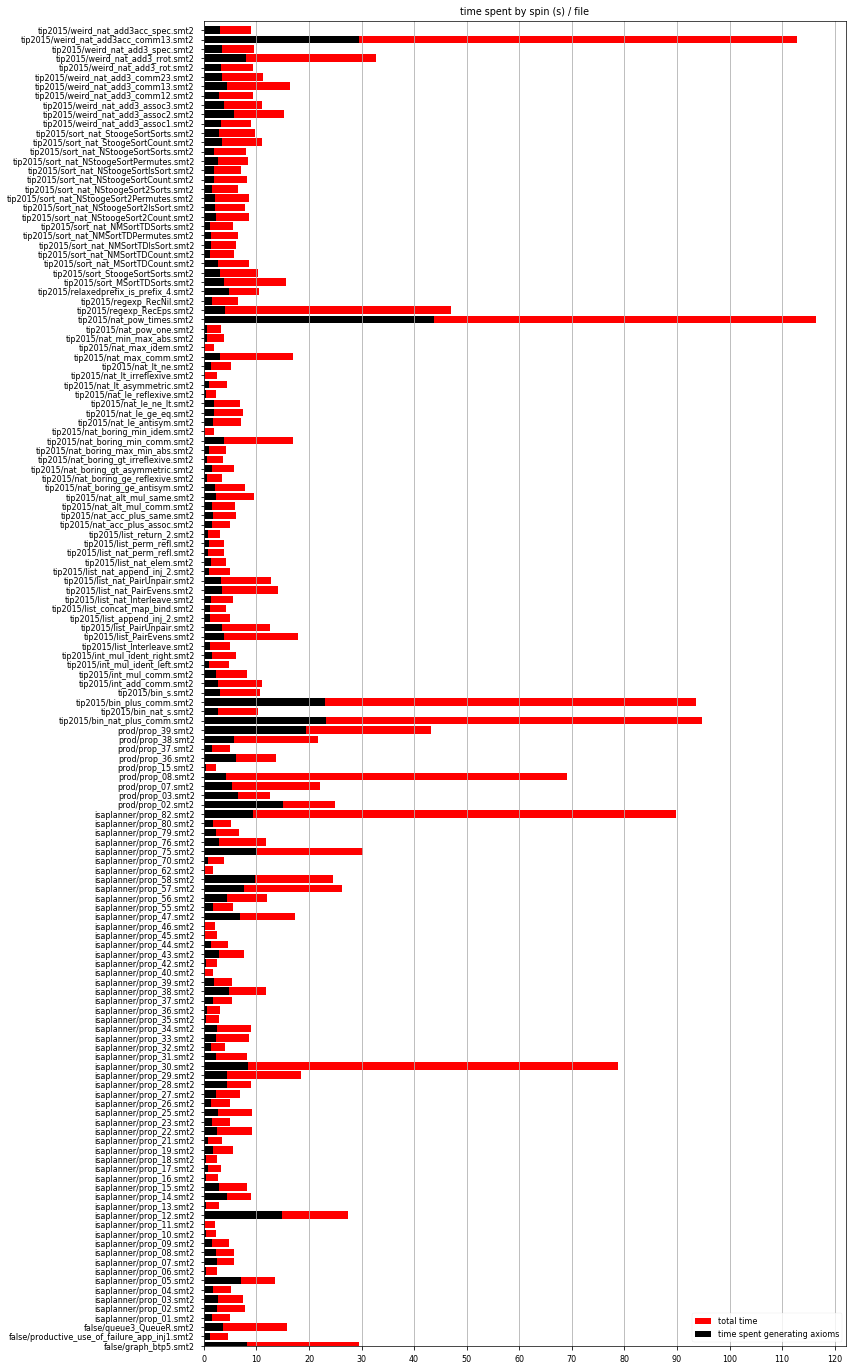

In [16]:
plt.figure( figsize=(12, 19) )
plt.grid( axis='x' )
plt.barh( spin_success['file'], spin_success['time_viper'] / 1000, color='r', label = "total time" )
plt.barh( spin_success['file'], spin_success['time_viper_axiom_gen'] / 1000, color='black', label = "time spent generating axioms" )
plt.legend()
plt.xticks( np.arange( 130, step=10 ) )
plt.ylim( [ 0, len(spin_success) ] )
plt.tight_layout()
plt.title( "time spent by spin (s) / file" )
plt.savefig('ax_gen_time.pdf')

In [17]:
axiomgen_total_ratio = spin_success['time_viper_axiom_gen'] / spin_success['time_viper']
axiomgen_total_ratio.describe()

count    142.000000
mean       0.270771
std        0.100442
min        0.012903
25%        0.221308
50%        0.264432
75%        0.320531
max        0.601056
dtype: float64

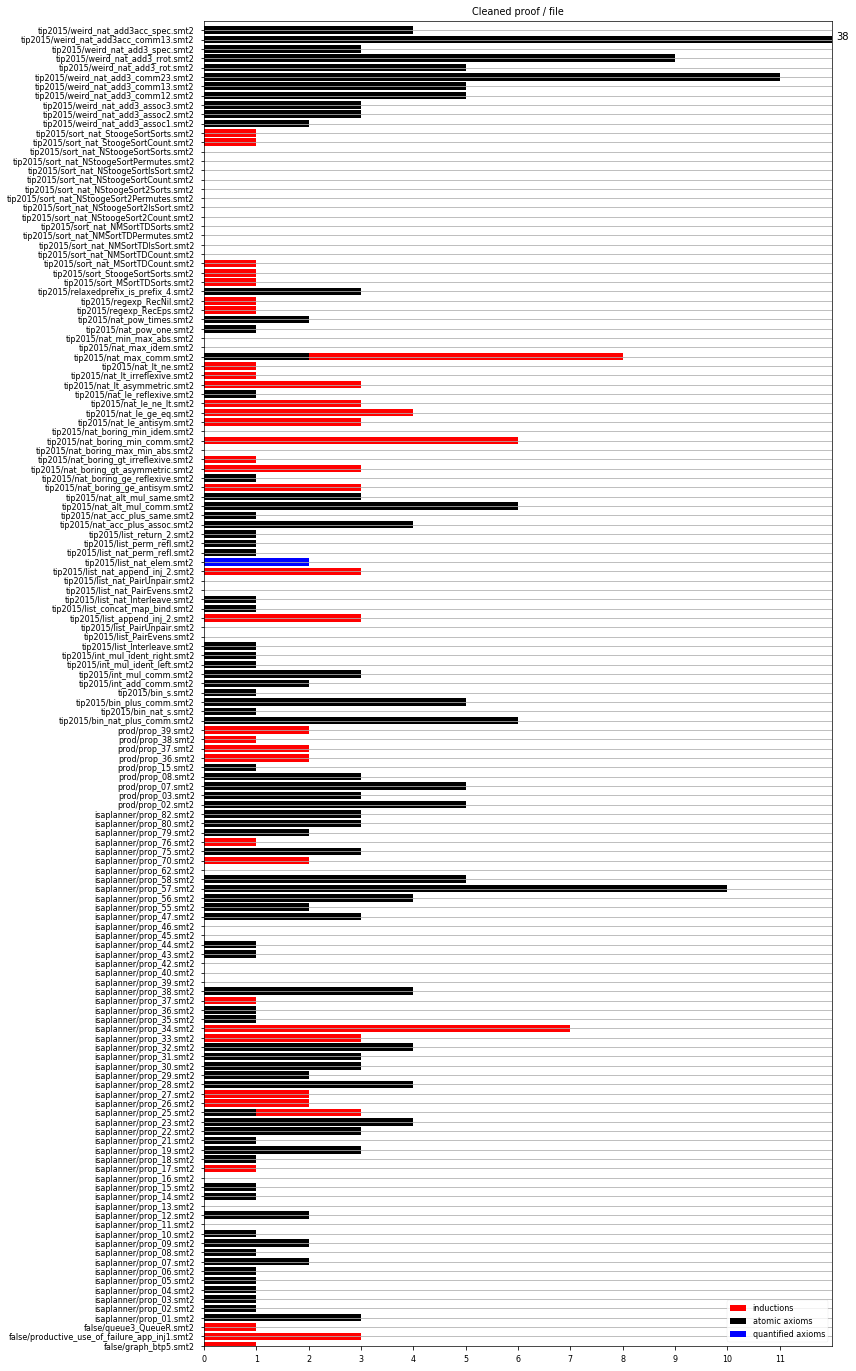

In [18]:
xlimit = 12

plt.figure( figsize=(12, 19) )
plt.xlim( 0, xlimit )
plt.ylim( [ 0, len(spin_success) ] )
plt.grid( axis='y' )
plt.barh( spin_success['file'], spin_success['inductions'], color='r', label = "inductions" )
plt.barh( spin_success['file'], spin_success['atomic'], color='black', label = "atomic axioms" )
plt.barh( spin_success['file'], spin_success['quantified'], color='blue', label = "quantified axioms" )

for i, v in enumerate( spin_success['atomic'] ):
    if v > xlimit:
        plt.text( xlimit+0.2, i, "%d" %v, ha="center", color='black' )

plt.legend()
plt.xticks( np.arange( xlimit ) )
plt.tight_layout()
plt.title( "Cleaned proof / file" )
plt.savefig("inductions_cleaned.pdf")

In [19]:
as_success = succeeded[succeeded['mode'] == 'analytic_sequential']

In [20]:
spin_and_as = succeeded[((succeeded['mode'] == "spin") | (succeeded['mode'] == "analytic_sequential")) & (succeeded['file'].isin( as_success['file'] ))]

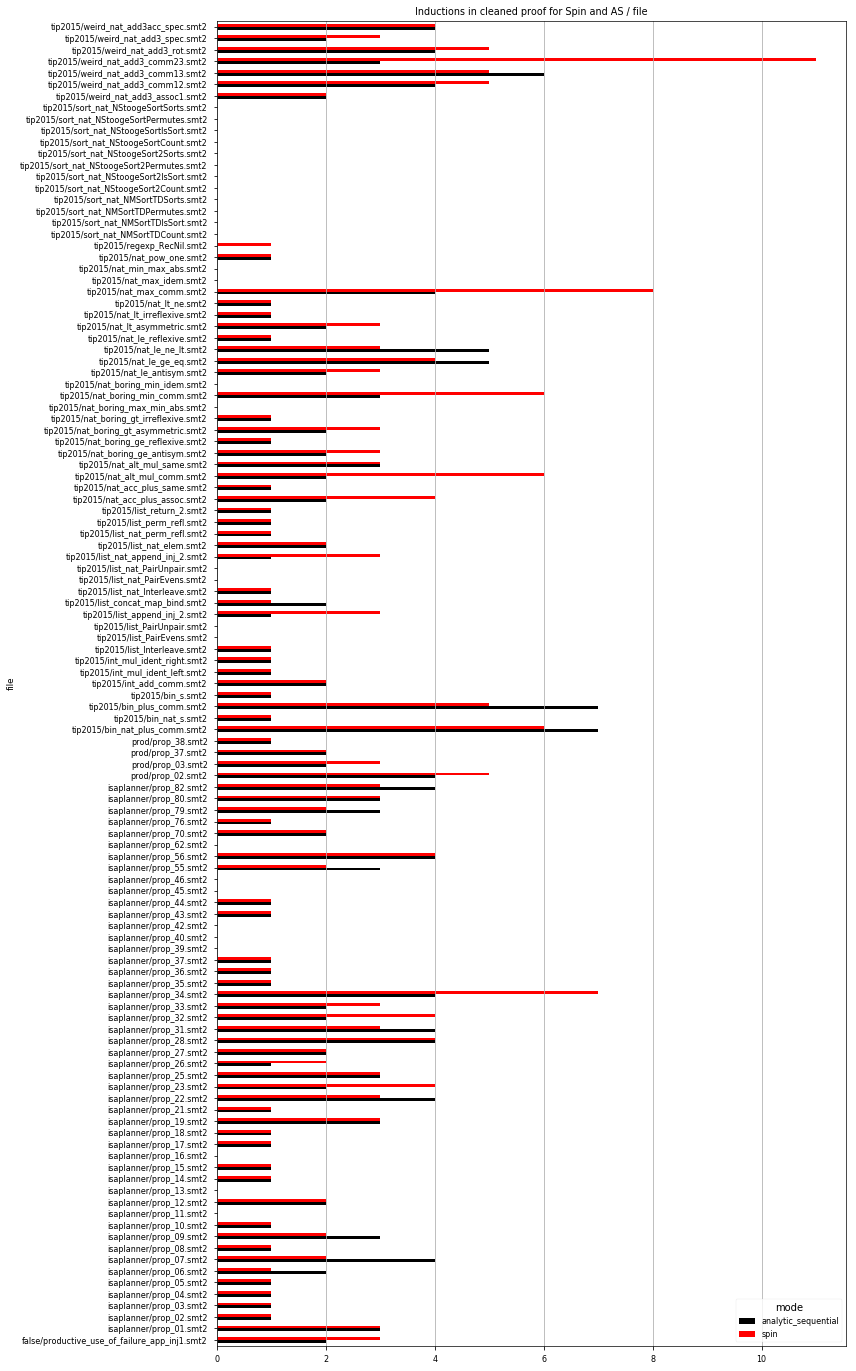

In [21]:
pivot = spin_and_as.dropna( subset = ['inductions'] ).pivot(index = "file", columns = "mode", values = "inductions")
pivot.plot.barh( figsize=( 12, 19 ), color = ['black', 'red'] )
plt.grid( axis='x' )
plt.tight_layout()
plt.title( "Inductions in cleaned proof for Spin and AS / file")
plt.savefig("inductions_spin_as.pdf")

In [22]:
nogen_success = succeeded[succeeded['mode'] == 'spin_nogen']

In [23]:
spin_and_nogen = succeeded[((succeeded['mode'] == "spin") | (succeeded['mode'] == "spin_nogen")) & (succeeded['file'].isin( nogen_success['file'] ))]

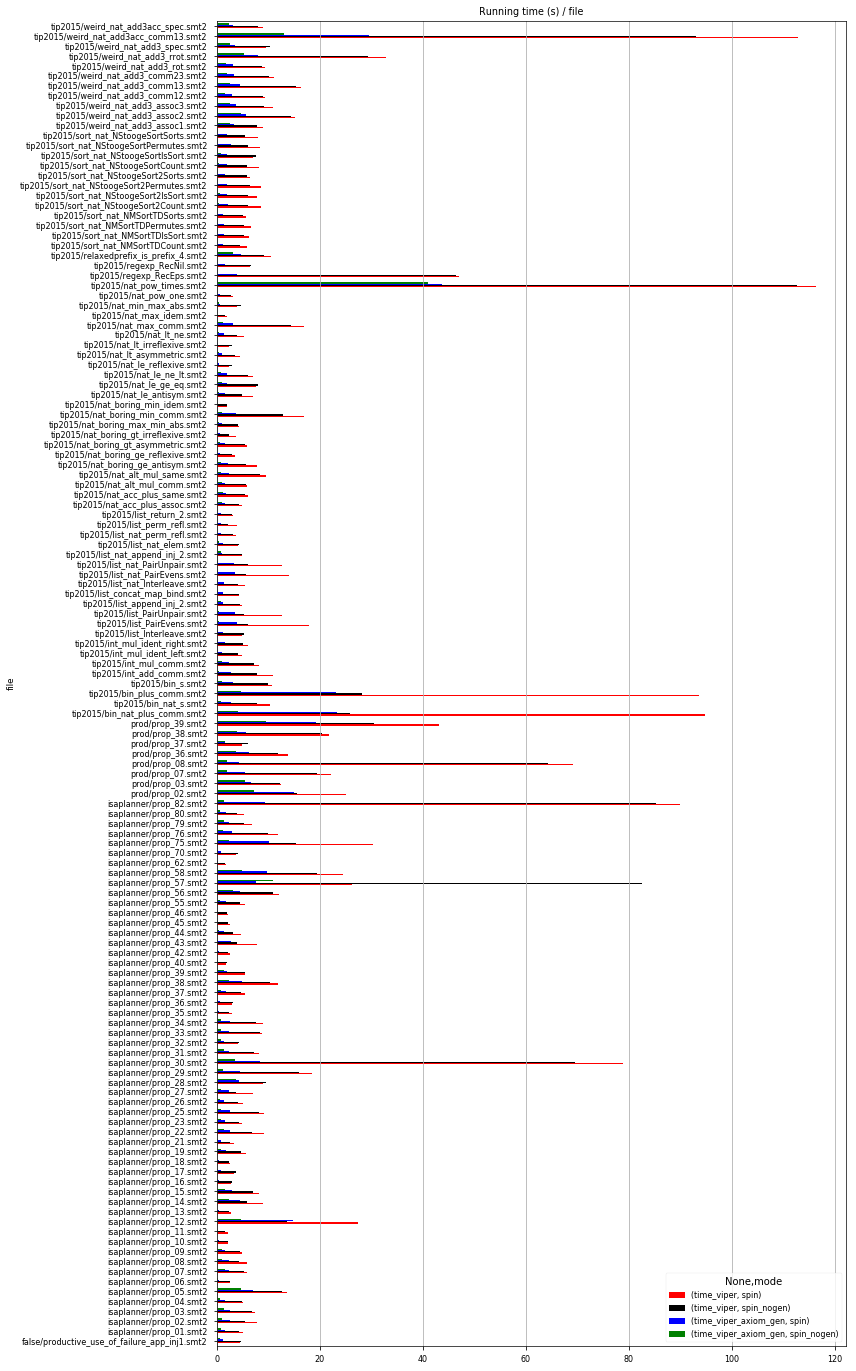

In [24]:
pivot = spin_and_nogen.dropna( subset = ['time_viper'] ).pivot(index = "file", columns = "mode", values = [ "time_viper", "time_viper_axiom_gen"] )
(pivot / 1000).plot.barh( figsize=( 12, 19 ), color = ['red', 'black', 'blue', 'green'] )
plt.grid( axis='x' )
plt.tight_layout()
plt.title( "Running time (s) / file")
plt.savefig("runtime_spin_nogen.pdf")

In [25]:
axiomgen_total_ratio_nogen = nogen_success['time_viper_axiom_gen'] / nogen_success['time_viper']
axiomgen_total_ratio_nogen.describe()

count    133.000000
mean       0.133377
std        0.106157
min        0.000620
25%        0.047154
50%        0.106043
75%        0.196503
max        0.465030
dtype: float64

In [26]:
spin_added_axioms = spin_success[spin_success['added_axioms'] > 0]

In [27]:
inductions_added_ratio = spin_added_axioms['inductions'] / ( spin_added_axioms['added_axioms'])
inductions_added_ratio.describe()

count    109.000000
mean       0.691979
std        0.932488
min        0.000000
25%        0.111111
50%        0.333333
75%        1.000000
max        6.000000
dtype: float64

In [28]:
pivot = succeeded.pivot_table( index=['file'], columns=['mode'] )
pivot

added_axioms             \
mode                                                  spin spin_nogen   
file                                                                    
false/graph_btp5.smt2                                  9.0        NaN   
false/productive_use_of_failure_app_inj1.smt2          0.0        0.0   
false/queue3_QueueR.smt2                               9.0        NaN   
isaplanner/prop_01.smt2                                2.0        2.0   
isaplanner/prop_02.smt2                                4.0        4.0   
isaplanner/prop_03.smt2                                6.0        6.0   
isaplanner/prop_04.smt2                                4.0        4.0   
isaplanner/prop_05.smt2                               22.0       22.0   
isaplanner/prop_06.smt2                                0.0        0.0   
isaplanner/prop_07.smt2                                6.0        6.0   
isaplanner/prop_08.smt2                                2.0        2.0   
isaplanner/prop_09.smt2                                1.0        1.0   
isaplanner/prop_10.smt2                                0.0        0.0   
isaplanner/prop_11.smt2                                0.0        0.0   
isaplanner/prop_12.smt2                               34.0       25.0   
isaplanner/prop_13.smt2                                0.0        0.0   
isaplanner/prop_14.smt2                                3.0        3.0   
isaplanner/prop_15.smt2                                8.0        8.0   
isaplanner/prop_16.smt2                                0.0        0.0   
isaplanner/prop_17.smt2                                0.0        0.0   
isaplanner/prop_18.smt2                                1.0        1.0   
isaplanner/prop_19.smt2                                2.0        2.0   
isaplanner/prop_21.smt2                                1.0        1.0   
isaplanner/prop_22.smt2                                4.0        4.0   
isaplanner/prop_23.smt2                                2.0        2.0   
isaplanner/prop_25.smt2                                4.0        3.0   
isaplanner/prop_26.smt2                                0.0        0.0   
isaplanner/prop_27.smt2                                0.0        0.0   
isaplanner/prop_28.smt2                               12.0       12.0   
isaplanner/prop_29.smt2                                9.0        6.0   
isaplanner/prop_30.smt2                               43.0       53.0   
isaplanner/prop_31.smt2                                4.0        4.0   
isaplanner/prop_32.smt2                                1.0        1.0   
isaplanner/prop_33.smt2                                1.0        1.0   
isaplanner/prop_34.smt2                                0.0        0.0   
isaplanner/prop_35.smt2                                1.0        1.0   
isaplanner/prop_36.smt2                                1.0        1.0   
isaplanner/prop_37.smt2                                6.0        6.0   
isaplanner/prop_38.smt2                               21.0       15.0   
isaplanner/prop_39.smt2                                2.0        2.0   
isaplanner/prop_40.smt2                                0.0        0.0   
isaplanner/prop_42.smt2                                0.0        0.0   
isaplanner/prop_43.smt2                                3.0        1.0   
isaplanner/prop_44.smt2                                1.0        1.0   
isaplanner/prop_45.smt2                                0.0        0.0   
isaplanner/prop_46.smt2                                0.0        0.0   
isaplanner/prop_47.smt2                               15.0        NaN   
isaplanner/prop_55.smt2                                2.0        2.0   
isaplanner/prop_56.smt2                               10.0       10.0   
isaplanner/prop_57.smt2                               28.0       65.0   
isaplanner/prop_58.smt2                               35.0       35.0   
isaplanner/prop_59.smt2                                NaN        NaN   
isaplanner/prop_62.smt2        

In [29]:
renamed = pivot.rename( index = str, columns = { 'analytic_sequential': 'as', 'analytic_independent': 'ai', 'treegrammar': 'tg' })
renamed

added_axioms             \
mode                                                  spin spin_nogen   
file                                                                    
false/graph_btp5.smt2                                  9.0        NaN   
false/productive_use_of_failure_app_inj1.smt2          0.0        0.0   
false/queue3_QueueR.smt2                               9.0        NaN   
isaplanner/prop_01.smt2                                2.0        2.0   
isaplanner/prop_02.smt2                                4.0        4.0   
isaplanner/prop_03.smt2                                6.0        6.0   
isaplanner/prop_04.smt2                                4.0        4.0   
isaplanner/prop_05.smt2                               22.0       22.0   
isaplanner/prop_06.smt2                                0.0        0.0   
isaplanner/prop_07.smt2                                6.0        6.0   
isaplanner/prop_08.smt2                                2.0        2.0   
isaplanner/prop_09.smt2                                1.0        1.0   
isaplanner/prop_10.smt2                                0.0        0.0   
isaplanner/prop_11.smt2                                0.0        0.0   
isaplanner/prop_12.smt2                               34.0       25.0   
isaplanner/prop_13.smt2                                0.0        0.0   
isaplanner/prop_14.smt2                                3.0        3.0   
isaplanner/prop_15.smt2                                8.0        8.0   
isaplanner/prop_16.smt2                                0.0        0.0   
isaplanner/prop_17.smt2                                0.0        0.0   
isaplanner/prop_18.smt2                                1.0        1.0   
isaplanner/prop_19.smt2                                2.0        2.0   
isaplanner/prop_21.smt2                                1.0        1.0   
isaplanner/prop_22.smt2                                4.0        4.0   
isaplanner/prop_23.smt2                                2.0        2.0   
isaplanner/prop_25.smt2                                4.0        3.0   
isaplanner/prop_26.smt2                                0.0        0.0   
isaplanner/prop_27.smt2                                0.0        0.0   
isaplanner/prop_28.smt2                               12.0       12.0   
isaplanner/prop_29.smt2                                9.0        6.0   
isaplanner/prop_30.smt2                               43.0       53.0   
isaplanner/prop_31.smt2                                4.0        4.0   
isaplanner/prop_32.smt2                                1.0        1.0   
isaplanner/prop_33.smt2                                1.0        1.0   
isaplanner/prop_34.smt2                                0.0        0.0   
isaplanner/prop_35.smt2                                1.0        1.0   
isaplanner/prop_36.smt2                                1.0        1.0   
isaplanner/prop_37.smt2                                6.0        6.0   
isaplanner/prop_38.smt2                               21.0       15.0   
isaplanner/prop_39.smt2                                2.0        2.0   
isaplanner/prop_40.smt2                                0.0        0.0   
isaplanner/prop_42.smt2                                0.0        0.0   
isaplanner/prop_43.smt2                                3.0        1.0   
isaplanner/prop_44.smt2                                1.0        1.0   
isaplanner/prop_45.smt2                                0.0        0.0   
isaplanner/prop_46.smt2                                0.0        0.0   
isaplanner/prop_47.smt2                               15.0        NaN   
isaplanner/prop_55.smt2                                2.0        2.0   
isaplanner/prop_56.smt2                               10.0       10.0   
isaplanner/prop_57.smt2                               28.0       65.0   
isaplanner/prop_58.smt2                               35.0       35.0   
isaplanner/prop_59.smt2                                NaN        NaN   
isaplanner/prop_62.smt2        

In [30]:
print( renamed.to_html() )

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="3" halign="left">added_axioms</th>
      <th colspan="6" halign="left">atomic</th>
      <th colspan="3" halign="left">candidates</th>
      <th colspan="6" halign="left">induction_depth</th>
      <th colspan="6" halign="left">inductions</th>
      <th colspan="6" halign="left">quantified</th>
      <th colspan="6" halign="left">time_viper</th>
      <th colspan="3" halign="left">time_viper_axiom_gen</th>
    </tr>
    <tr>
      <th>mode</th>
      <th>spin</th>
      <th>spin_nogen</th>
      <th>spin_notest</th>
      <th>ai</th>
      <th>as</th>
      <th>spin</th>
      <th>spin_nogen</th>
      <th>spin_notest</th>
      <th>tg</th>
      <th>spin</th>
      <th>spin_nogen</th>
      <th>spin_notest</th>
      <th>ai</th>
      <th>as</th>
      <th>spin</th>
      <th>spin_nogen</th>
      <th>spin_notest</th>
      <th>tg</th>
      <th>ai</th>
      <th>as</th>
      <th>spin</th>
    

In [31]:
for file in sorted( spin_files ):
    print( file )

false/graph_btp5.smt2
false/productive_use_of_failure_app_inj1.smt2
false/queue3_QueueR.smt2
isaplanner/prop_01.smt2
isaplanner/prop_02.smt2
isaplanner/prop_03.smt2
isaplanner/prop_04.smt2
isaplanner/prop_05.smt2
isaplanner/prop_06.smt2
isaplanner/prop_07.smt2
isaplanner/prop_08.smt2
isaplanner/prop_09.smt2
isaplanner/prop_10.smt2
isaplanner/prop_11.smt2
isaplanner/prop_12.smt2
isaplanner/prop_13.smt2
isaplanner/prop_14.smt2
isaplanner/prop_15.smt2
isaplanner/prop_16.smt2
isaplanner/prop_17.smt2
isaplanner/prop_18.smt2
isaplanner/prop_19.smt2
isaplanner/prop_21.smt2
isaplanner/prop_22.smt2
isaplanner/prop_23.smt2
isaplanner/prop_25.smt2
isaplanner/prop_26.smt2
isaplanner/prop_27.smt2
isaplanner/prop_28.smt2
isaplanner/prop_29.smt2
isaplanner/prop_30.smt2
isaplanner/prop_31.smt2
isaplanner/prop_32.smt2
isaplanner/prop_33.smt2
isaplanner/prop_34.smt2
isaplanner/prop_35.smt2
isaplanner/prop_36.smt2
isaplanner/prop_37.smt2
isaplanner/prop_38.smt2
isaplanner/prop_39.smt2
isaplanner/prop_40.